In [ ]:
# Install all packages
# Restart runtime after installation

#!wget https://github.com/PranjalSahu/ITKThinShellDemons/raw/pranjal_setup/itk_thinshelldemons-0.1.1-cp38-cp38m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk_thinshelldemons-0.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets

In [1]:
# Import all packages

import numpy as np
#import itkConfig
#itkConfig.LazyLoading = False
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk
# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [3]:
print(itk.__version__)

5.3.0


In [4]:
# Helper Functions

def subsample_points(inputmesh, mesh_sub_sample_points, seed):
    import vtk
    from vtk.util import numpy_support

    sample = vtk.vtkPolyDataPointSampler()
    sample.SetInputData(inputmesh)
    sample.SetGenerateEdgePoints(0)
    sample.SetGenerateInteriorPoints(0)
    sample.SetPointGenerationModeToRegular()
    sample.SetDistance(0.5)
    sample.Update()

    sampled_points = sample.GetOutput()

    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    np.random.seed(seed)
    random_indices = np.random.choice(as_numpy.shape[0],
                                      size=mesh_sub_sample_points,
                                      replace=False)
    as_numpy_sampled = as_numpy[random_indices, :]

    return as_numpy_sampled

# returns the points in numpy array
def subsample_points_poisson(inputMesh):
    import vtk
    from vtk.util import numpy_support
    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(4.5)
    f.Update()
    
    sampled_points = f.GetOutput()
    points = sampled_points.GetPoints()
    pointdata = points.GetData()
    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    return as_numpy

# Returns vtk points so that it has normal data also in it
def subsample_points_poisson_polydata(inputMesh):
    import vtk
    from vtk.util import numpy_support
    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(4.5)
    f.Update()
    sampled_points = f.GetOutput()
    return sampled_points

# Extracts the normal data from the sampled points
def extract_normal_from_tuple(input_mesh):
    t1 = input_mesh.GetPointData().GetArray("Normals")
    n1_array = []
    for i in range(t1.GetNumberOfTuples()):
        n1_array.append(t1.GetTuple(i))
    n1_array = np.array(n1_array)
    
    points = input_mesh.GetPoints()
    pointdata = points.GetData()
    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    return as_numpy, n1_array

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

# set the normal obtained from vtk to itk mesh
def set_normal_data_itk(input_pointset, input_normal):
    for i in range(input_pointset.GetNumberOfPoints()):
        pixel_data_reference = input_pointset.GetPointData().CreateElementAt(i)
        pixel_data_reference[0] = input_normal[i][0]
        pixel_data_reference[1] = input_normal[i][1]
        pixel_data_reference[2] = input_normal[i][2]
    return

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def getnormals(inputmesh):
    normals = vtk.vtkTriangleMeshPointNormals()
    normals.SetInputData(inputmesh)
    normals.Update()
    return normals.GetOutput()

def convert_vtk_pointset_to_polydata(input_pointset):
    vd = vtk.vtkPolyData()
    vd.SetPoints(input_pointset.GetPoints())
    n1 = movingMeshPoints.GetPointData().GetArray("Normals")
    vd.GetPointData().SetScalars(n1)

    # Write the polydata for testing
    vdw = vtk.vtkPolyDataWriter()
    vdw.SetFileName('test1.vtk')
    vdw.SetInputData(vd)
    vdw.SetFileTypeToASCII()
    vdw.Update()

In [3]:
# File paths

#MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Pan/meshes/USNM220065-Cranium_merged_1.ply'
#FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM252575-Cranium.ply'

# ransac registered
MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData1/USNM174701-Cranium_merged_1.ply'
# original mesh
#MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium.ply'

FIXED_MESH_FILE  = '/home/pranjal.sahu/Documents/SampleApeData1/USNM174722-Cranium.ply'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [10]:
# Fetch the files

FIXED_MESH_FILE  = r'data/129S1_SVIMJ_.ply'
MOVING_MESH_FILE = r'data/129X1_SVJ_.ply'
paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

import os
import importlib
from urllib.request import urlretrieve

# Download meshes
os.makedirs('data',exist_ok=True)
if not os.path.exists(FIXED_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129S1_SVIMJ_.ply'
    urlretrieve(url, FIXED_MESH_FILE)
if not os.path.exists(MOVING_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129X1_SVJ_.ply'
    urlretrieve(url, MOVING_MESH_FILE)

In [3]:
# Clean the meshes and Triangulate them as TSD only works with Triangle Meshes

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
        
    cleaner = vtk.vtkCleanPolyData()
    cleaner.SetInputData(reader.GetOutput())
    cleaner.ConvertLinesToPointsOn()
    cleaner.ConvertPolysToLinesOff()
    cleaner.SetTolerance(0.0)
    cleaner.Update()
    vtk_mesh = cleaner.GetOutput()

    triangle_filter = vtk.vtkTriangleFilter()
    triangle_filter.SetInputData(vtk_mesh)
    triangle_filter.SetPassLines(False)
    triangle_filter.SetPassVerts(False)
    triangle_filter.Update()
    vtk_mesh = triangle_filter.GetOutput()
    
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [4]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []
# itk_meshes = []
# itk_meshes.append(itk.meshread('itk_meshes_0.vtk'))
# itk_meshes.append(itk.meshread('itk_meshes_1.vtk'))

itk_images = []
for mesh in itk_meshes:
    # Get all the points to positive values
    temp = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(temp, 0)
    temp = temp - m
    mesh.SetPoints(itk.vector_container_from_array(temp.flatten())) 
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
                                                         

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [5]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

fixedMesh  = itk_meshes[0]#itk_transformed_meshes[0]
movingMesh = itk_meshes[1]#itk_transformed_meshes[1]


w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

#itk.meshwrite(movingMesh, 'movingMesh.vtk')
#itk.meshwrite(fixedMesh, 'fixedMesh.vtk')

In [3]:
movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

#print(fixedMeshPoints.shape)

def get_bounding_box_data(inputMeshPoints):
    ElementIdentifierType = itk.UL
    CoordType = itk.F
    Dimension = 3

    VecContType = itk.VectorContainer[
        ElementIdentifierType, itk.Point[CoordType, Dimension]
    ]

    ps = itk.PointSet.D3.New()
    ps.SetPoints(itk.vector_container_from_array(inputMeshPoints.flatten()))

    bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
    bounding_box.SetPoints(ps.GetPoints())
    bounding_box.ComputeBoundingBox()

    minBounds = np.array(bounding_box.GetMinimum())
    maxBounds = np.array(bounding_box.GetMaximum())
    
    return maxBounds - minBounds, bounding_box.GetCenter()

def scale_mesh(input_mesh, scale_factor):
    mesh_points = itk.array_from_vector_container(input_mesh.GetPoints())
    mesh_points =  mesh_points * scale_factor
    input_mesh.SetPoints(itk.vector_container_from_array(mesh_points.flatten()))
    return input_mesh
    
def perform_scaling_and_centering(movingPoints, fixedPoints, movingMesh, fixedMesh):
    sourceSize = np.linalg.norm(np.max(movingPoints, 0) - np.min(movingPoints, 0))
    targetSize = np.linalg.norm(np.max(fixedPoints, 0) - np.min(fixedPoints, 0))

    scaling = (targetSize)/sourceSize

    scaledMovingPoints = movingPoints * scaling
    scaledMovingMesh   = scale_mesh(movingMesh, scaling)
    
    return scaledMovingPoints, scaledMovingMesh

movingMesh = itk.meshread(movingMeshPath, itk.D)
fixedMesh  = itk.meshread(fixedMeshPath, itk.D)

movingMeshPoints, scaledMovingMesh = perform_scaling_and_centering(movingMeshPoints, fixedMeshPoints, movingMesh, fixedMesh)

print(movingMeshPoints.shape, scaledMovingMesh.GetNumberOfPoints())

# w1 = itk.MeshFileWriter[type(scaledMovingMesh)].New()
# w1.SetFileName('movingMeshScaled.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(scaledMovingMesh)
# w1.Update()

(3754, 3) 2209640


In [ ]:
# movingMeshPath = 'movingMeshScaled.vtk'
# fixedMeshPath = 'fixedMesh.vtk'

# movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
# fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'


movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

itkwidgets.view(geometries=[fixedMesh, movingMesh])

In [20]:
# For performing RANSAC in parallel

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk

def get_euclidean_distance():
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))
    
    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.Initialize()
    
def final_iteration(fixedPoints, movingPoints, transform_type):
    mesh_fixed = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()

    mesh_fixed.SetPoints(itk.vector_container_from_array(
        fixedPoints.flatten()))
    mesh_moving.SetPoints(
        itk.vector_container_from_array(movingPoints.flatten()))

    if transform_type == 0:
        TransformType = itk.Euler3DTransform[itk.D]
        #TransformType = itk.Rigid3DTransform[itk.D]
    elif transform_type == 1:
        TransformType = itk.ScaleVersor3DTransform[itk.D]
    elif transform_type == 2:
        TransformType = itk.Similarity3DTransform[itk.D]
    else:
        TransformType = itk.AffineTransform[itk.D, 3]

    transform = TransformType.New()
    transform.SetIdentity()

    MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
    #MetricType = itk.PointToPlanePointSetToPointSetMetricv4.PSD3
    metric = MetricType.New()
    metric.SetMovingPointSet(mesh_moving)
    metric.SetFixedPointSet(mesh_fixed)
    metric.SetMovingTransform(transform)
    metric.Initialize()

    print('Initial Value ', metric.GetValue())    
    number_of_epochs = 5000
    optimizer = itk.GradientDescentOptimizerv4Template[itk.D].New()
    optimizer.SetNumberOfIterations(number_of_epochs)
    optimizer.SetLearningRate(0.0001)
    optimizer.SetMinimumConvergenceValue(0.0)
    optimizer.SetConvergenceWindowSize(number_of_epochs)
    optimizer.SetMetric(metric)

    def print_iteration():
        print(f"It: {optimizer.GetCurrentIteration()}"
              f" metric value: {optimizer.GetCurrentMetricValue():.6f} ")

    optimizer.AddObserver(itk.IterationEvent(), print_iteration)
    optimizer.StartOptimization()

    print('Final Value ', metric.GetValue())
    
    if 0:
        current_transform = metric.GetMovingTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_fixed, transform=current_transform)
    else:
        current_transform = metric.GetMovingTransform().GetInverseTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

    return itk.array_from_vector_container(itk_transformed_mesh.GetPoints())

def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    import numpy as np
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        # Create Mesh inside the method to tackle the problem of serialization
        
        import itk
        
        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()
        
        # Create small point sets
        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        if transform_type == 0:
            # works best
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            # does not work well
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            # works ok
            TransformType = itk.Similarity3DTransform[itk.D]
        else:
            TransformType = itk.AffineTransform[itk.D, 3]

        transform = TransformType.New()
        transform.SetIdentity()
        
        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()
                
        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
        optimizer.SetNumberOfIterations(20)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 20 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

#         optimizer = itk.GradientDescentOptimizerv4Template.D.New()
#         optimizer.SetNumberOfIterations(200)
#         optimizer.SetLearningRate(0.0001)
#         #optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
#         optimizer.SetMinimumConvergenceValue( 0.0 )
#         optimizer.SetConvergenceWindowSize( 200 )
#         optimizer.SetMetric(metric)
#         optimizer.StartOptimization()
        
        
        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        #current_transform = itk.dict_from_transform(current_transform)

        if return_result:
            mesh_moving = itk.Mesh[itk.D, 3].New()
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshPoints.flatten()))
            
            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)
            
            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            return (current_value, i)
        #if current_value < 7:
        #    return (current_value, i)
        #else:
        #    return (current_value, -1)

    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))
    results = sorted(results)

    print(results[0])
    final_result = process(results[0][1], mesh_sub_sample_points,
                           number_of_ransac_points, 1)
    #movingMesh.SetPoints(itk.vector_container_from_array(final_result.flatten()))
    
    return final_result

import time

number_of_iterations = 1000
number_of_ransac_points = 100
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 0

#movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
#fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshNormals = getnormals(movingMesh)
fixedMeshNormals = getnormals(fixedMesh)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

# Sample the points
movingMeshPoints = subsample_points_poisson_polydata(movingMeshNormals)
fixedMeshPoints  = subsample_points_poisson_polydata(fixedMeshNormals)

# Obtain normals from the sub-sampled points
movingMeshPoints, movingMeshPointNormals = extract_normal_from_tuple(movingMeshPoints)
fixedMeshPoints, fixedMeshPointNormals = extract_normal_from_tuple(fixedMeshPoints)

print(movingMeshPoints.shape, fixedMeshPoints.shape)
print(movingMeshPointNormals.shape, fixedMeshPointNormals.shape)

def scale_mesh(input_mesh, scale_factor):
    mesh_points = itk.array_from_vector_container(input_mesh.GetPoints())
    print(mesh_points.shape, mesh_points.dtype)
    mesh_points =  mesh_points * scale_factor
    input_mesh.SetPoints(itk.vector_container_from_array(mesh_points.flatten()))
    return input_mesh
    
def perform_scaling_and_centering(movingPoints, fixedPoints, movingMesh, fixedMesh):
    sourceSize = np.linalg.norm(np.max(movingPoints, 0) - np.min(movingPoints, 0))
    targetSize = np.linalg.norm(np.max(fixedPoints, 0) - np.min(fixedPoints, 0))

    scaling = (targetSize)/sourceSize

    scaledMovingPoints = movingPoints * scaling
    scaledMovingMesh   = scale_mesh(movingMesh, scaling)
    
    return scaledMovingPoints, scaledMovingMesh

movingMesh = itk.meshread(movingMeshPath, itk.D)
fixedMesh  = itk.meshread(fixedMeshPath, itk.D)

movingMeshPoints, scaledMovingMesh = perform_scaling_and_centering(movingMeshPoints, fixedMeshPoints, movingMesh, fixedMesh)

print(movingMeshPoints.shape, scaledMovingMesh.GetNumberOfPoints())

# w1 = itk.MeshFileWriter[type(scaledMovingMesh)].New()
# w1.SetFileName('movingMeshScaled.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(scaledMovingMesh)
# w1.Update()

if 1:
    start_time = time.time()
    transform_type = 2
    itk_transformed_points = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
                                                 movingMeshAllPoints,
                                                 number_of_iterations,
                                                 mesh_sub_sample_points,
                                                 number_of_ransac_points,
                                                 transform_type, convergence_value)
    end_time = time.time()

    print(end_time - start_time)
    print('itk_transformed_points shape ', itk_transformed_points.shape)
    
    transform_type = 0
    final_mesh = final_iteration(fixedMeshPoints, itk_transformed_points, transform_type)

#     newmesh = itk.Mesh.D3.New()
#     newmesh.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))

#     w1 = itk.MeshFileWriter[type(newmesh)].New()
#     w1.SetFileName('ransacICPResult2_b.vtk')
#     w1.SetFileTypeAsBINARY()
#     w1.SetInput(newmesh)
#     w1.Update()

(3754, 3) (8002, 3)
(3754, 3) (8002, 3)
(2209640, 3) float32
(3754, 3) 2209640
(8.49899403437384, 32)
21.7491614818573
itk_transformed_points shape  (3754, 3)
Initial Value  8.49899403437384
It: 0 metric value: 8.498994 
It: 1 metric value: 7.817108 
It: 2 metric value: 7.721084 
It: 3 metric value: 7.707769 
It: 4 metric value: 7.709746 
It: 5 metric value: 7.711898 
It: 6 metric value: 7.711827 
It: 7 metric value: 7.710548 
It: 8 metric value: 7.708596 
It: 9 metric value: 7.705669 
It: 10 metric value: 7.703162 
It: 11 metric value: 7.700252 
It: 12 metric value: 7.696186 
It: 13 metric value: 7.692433 
It: 14 metric value: 7.689062 
It: 15 metric value: 7.685374 
It: 16 metric value: 7.681963 
It: 17 metric value: 7.679404 
It: 18 metric value: 7.676567 
It: 19 metric value: 7.673431 
It: 20 metric value: 7.670016 
It: 21 metric value: 7.666294 
It: 22 metric value: 7.663272 
It: 23 metric value: 7.660194 
It: 24 metric value: 7.656590 
It: 25 metric value: 7.652924 
It: 26 metric

It: 325 metric value: 7.548124 
It: 326 metric value: 7.548030 
It: 327 metric value: 7.547995 
It: 328 metric value: 7.547965 
It: 329 metric value: 7.547939 
It: 330 metric value: 7.547915 
It: 331 metric value: 7.547925 
It: 332 metric value: 7.547892 
It: 333 metric value: 7.547892 
It: 334 metric value: 7.547811 
It: 335 metric value: 7.547819 
It: 336 metric value: 7.547780 
It: 337 metric value: 7.547763 
It: 338 metric value: 7.547795 
It: 339 metric value: 7.547680 
It: 340 metric value: 7.547715 
It: 341 metric value: 7.547674 
It: 342 metric value: 7.547663 
It: 343 metric value: 7.547630 
It: 344 metric value: 7.547610 
It: 345 metric value: 7.547575 
It: 346 metric value: 7.547580 
It: 347 metric value: 7.547560 
It: 348 metric value: 7.547510 
It: 349 metric value: 7.547493 
It: 350 metric value: 7.547449 
It: 351 metric value: 7.547422 
It: 352 metric value: 7.547345 
It: 353 metric value: 7.547411 
It: 354 metric value: 7.547320 
It: 355 metric value: 7.547332 
It: 356 

It: 659 metric value: 7.539969 
It: 660 metric value: 7.539990 
It: 661 metric value: 7.540005 
It: 662 metric value: 7.539862 
It: 663 metric value: 7.539918 
It: 664 metric value: 7.539835 
It: 665 metric value: 7.539831 
It: 666 metric value: 7.539770 
It: 667 metric value: 7.539785 
It: 668 metric value: 7.539764 
It: 669 metric value: 7.539773 
It: 670 metric value: 7.539802 
It: 671 metric value: 7.539615 
It: 672 metric value: 7.539666 
It: 673 metric value: 7.539702 
It: 674 metric value: 7.539603 
It: 675 metric value: 7.539632 
It: 676 metric value: 7.539564 
It: 677 metric value: 7.539642 
It: 678 metric value: 7.539574 
It: 679 metric value: 7.539479 
It: 680 metric value: 7.539527 
It: 681 metric value: 7.539460 
It: 682 metric value: 7.539495 
It: 683 metric value: 7.539344 
It: 684 metric value: 7.539421 
It: 685 metric value: 7.539384 
It: 686 metric value: 7.539368 
It: 687 metric value: 7.539320 
It: 688 metric value: 7.539353 
It: 689 metric value: 7.539232 
It: 690 

It: 1015 metric value: 7.531323 
It: 1016 metric value: 7.531290 
It: 1017 metric value: 7.531156 
It: 1018 metric value: 7.531224 
It: 1019 metric value: 7.531163 
It: 1020 metric value: 7.531035 
It: 1021 metric value: 7.531062 
It: 1022 metric value: 7.531112 
It: 1023 metric value: 7.531059 
It: 1024 metric value: 7.531005 
It: 1025 metric value: 7.531091 
It: 1026 metric value: 7.530980 
It: 1027 metric value: 7.531042 
It: 1028 metric value: 7.530979 
It: 1029 metric value: 7.530938 
It: 1030 metric value: 7.530900 
It: 1031 metric value: 7.530878 
It: 1032 metric value: 7.530880 
It: 1033 metric value: 7.530861 
It: 1034 metric value: 7.530772 
It: 1035 metric value: 7.530834 
It: 1036 metric value: 7.530712 
It: 1037 metric value: 7.530777 
It: 1038 metric value: 7.530694 
It: 1039 metric value: 7.530737 
It: 1040 metric value: 7.530674 
It: 1041 metric value: 7.530638 
It: 1042 metric value: 7.530676 
It: 1043 metric value: 7.530639 
It: 1044 metric value: 7.530569 
It: 1045 m

It: 1380 metric value: 7.523042 
It: 1381 metric value: 7.522945 
It: 1382 metric value: 7.522988 
It: 1383 metric value: 7.522902 
It: 1384 metric value: 7.522858 
It: 1385 metric value: 7.522863 
It: 1386 metric value: 7.522882 
It: 1387 metric value: 7.522828 
It: 1388 metric value: 7.522862 
It: 1389 metric value: 7.522758 
It: 1390 metric value: 7.522718 
It: 1391 metric value: 7.522742 
It: 1392 metric value: 7.522757 
It: 1393 metric value: 7.522592 
It: 1394 metric value: 7.522678 
It: 1395 metric value: 7.522604 
It: 1396 metric value: 7.522671 
It: 1397 metric value: 7.522561 
It: 1398 metric value: 7.522529 
It: 1399 metric value: 7.522540 
It: 1400 metric value: 7.522523 
It: 1401 metric value: 7.522485 
It: 1402 metric value: 7.522506 
It: 1403 metric value: 7.522456 
It: 1404 metric value: 7.522437 
It: 1405 metric value: 7.522417 
It: 1406 metric value: 7.522374 
It: 1407 metric value: 7.522395 
It: 1408 metric value: 7.522304 
It: 1409 metric value: 7.522330 
It: 1410 m

It: 1733 metric value: 7.515079 
It: 1734 metric value: 7.514927 
It: 1735 metric value: 7.515024 
It: 1736 metric value: 7.514900 
It: 1737 metric value: 7.514973 
It: 1738 metric value: 7.514866 
It: 1739 metric value: 7.514936 
It: 1740 metric value: 7.514823 
It: 1741 metric value: 7.514975 
It: 1742 metric value: 7.514884 
It: 1743 metric value: 7.514912 
It: 1744 metric value: 7.514882 
It: 1745 metric value: 7.514870 
It: 1746 metric value: 7.514830 
It: 1747 metric value: 7.514839 
It: 1748 metric value: 7.514750 
It: 1749 metric value: 7.514689 
It: 1750 metric value: 7.514669 
It: 1751 metric value: 7.514664 
It: 1752 metric value: 7.514593 
It: 1753 metric value: 7.514557 
It: 1754 metric value: 7.514517 
It: 1755 metric value: 7.514552 
It: 1756 metric value: 7.514516 
It: 1757 metric value: 7.514453 
It: 1758 metric value: 7.514435 
It: 1759 metric value: 7.514428 
It: 1760 metric value: 7.514397 
It: 1761 metric value: 7.514371 
It: 1762 metric value: 7.514329 
It: 1763 m

It: 2104 metric value: 7.506507 
It: 2105 metric value: 7.506429 
It: 2106 metric value: 7.506516 
It: 2107 metric value: 7.506294 
It: 2108 metric value: 7.506428 
It: 2109 metric value: 7.506237 
It: 2110 metric value: 7.506391 
It: 2111 metric value: 7.506270 
It: 2112 metric value: 7.506363 
It: 2113 metric value: 7.506150 
It: 2114 metric value: 7.506289 
It: 2115 metric value: 7.506103 
It: 2116 metric value: 7.506232 
It: 2117 metric value: 7.506079 
It: 2118 metric value: 7.506257 
It: 2119 metric value: 7.506005 
It: 2120 metric value: 7.506193 
It: 2121 metric value: 7.505978 
It: 2122 metric value: 7.506119 
It: 2123 metric value: 7.505913 
It: 2124 metric value: 7.506107 
It: 2125 metric value: 7.505871 
It: 2126 metric value: 7.506018 
It: 2127 metric value: 7.505878 
It: 2128 metric value: 7.505942 
It: 2129 metric value: 7.505926 
It: 2130 metric value: 7.505811 
It: 2131 metric value: 7.505962 
It: 2132 metric value: 7.505689 
It: 2133 metric value: 7.505934 
It: 2134 m

It: 2359 metric value: 7.500663 
It: 2360 metric value: 7.500594 
It: 2361 metric value: 7.500611 
It: 2362 metric value: 7.500518 
It: 2363 metric value: 7.500608 
It: 2364 metric value: 7.500574 
It: 2365 metric value: 7.500571 
It: 2366 metric value: 7.500510 
It: 2367 metric value: 7.500469 
It: 2368 metric value: 7.500491 
It: 2369 metric value: 7.500482 
It: 2370 metric value: 7.500403 
It: 2371 metric value: 7.500415 
It: 2372 metric value: 7.500386 
It: 2373 metric value: 7.500400 
It: 2374 metric value: 7.500300 
It: 2375 metric value: 7.500292 
It: 2376 metric value: 7.500320 
It: 2377 metric value: 7.500264 
It: 2378 metric value: 7.500287 
It: 2379 metric value: 7.500196 
It: 2380 metric value: 7.500248 
It: 2381 metric value: 7.500109 
It: 2382 metric value: 7.500069 
It: 2383 metric value: 7.500113 
It: 2384 metric value: 7.500199 
It: 2385 metric value: 7.499975 
It: 2386 metric value: 7.500045 
It: 2387 metric value: 7.500121 
It: 2388 metric value: 7.499996 
It: 2389 m

It: 2720 metric value: 7.492101 
It: 2721 metric value: 7.492140 
It: 2722 metric value: 7.492087 
It: 2723 metric value: 7.491987 
It: 2724 metric value: 7.492013 
It: 2725 metric value: 7.491962 
It: 2726 metric value: 7.491992 
It: 2727 metric value: 7.491964 
It: 2728 metric value: 7.491923 
It: 2729 metric value: 7.491925 
It: 2730 metric value: 7.491896 
It: 2731 metric value: 7.491841 
It: 2732 metric value: 7.491829 
It: 2733 metric value: 7.491783 
It: 2734 metric value: 7.491764 
It: 2735 metric value: 7.491805 
It: 2736 metric value: 7.491791 
It: 2737 metric value: 7.491741 
It: 2738 metric value: 7.491682 
It: 2739 metric value: 7.491685 
It: 2740 metric value: 7.491648 
It: 2741 metric value: 7.491613 
It: 2742 metric value: 7.491570 
It: 2743 metric value: 7.491615 
It: 2744 metric value: 7.491586 
It: 2745 metric value: 7.491567 
It: 2746 metric value: 7.491496 
It: 2747 metric value: 7.491543 
It: 2748 metric value: 7.491423 
It: 2749 metric value: 7.491483 
It: 2750 m

It: 3094 metric value: 7.484187 
It: 3095 metric value: 7.484146 
It: 3096 metric value: 7.484103 
It: 3097 metric value: 7.484119 
It: 3098 metric value: 7.484089 
It: 3099 metric value: 7.484044 
It: 3100 metric value: 7.484058 
It: 3101 metric value: 7.483994 
It: 3102 metric value: 7.483964 
It: 3103 metric value: 7.483986 
It: 3104 metric value: 7.483967 
It: 3105 metric value: 7.483915 
It: 3106 metric value: 7.483923 
It: 3107 metric value: 7.483879 
It: 3108 metric value: 7.483874 
It: 3109 metric value: 7.483834 
It: 3110 metric value: 7.483840 
It: 3111 metric value: 7.483769 
It: 3112 metric value: 7.483757 
It: 3113 metric value: 7.483745 
It: 3114 metric value: 7.483729 
It: 3115 metric value: 7.483731 
It: 3116 metric value: 7.483708 
It: 3117 metric value: 7.483705 
It: 3118 metric value: 7.483594 
It: 3119 metric value: 7.483570 
It: 3120 metric value: 7.483626 
It: 3121 metric value: 7.483588 
It: 3122 metric value: 7.483656 
It: 3123 metric value: 7.483481 
It: 3124 m

It: 3347 metric value: 7.478799 
It: 3348 metric value: 7.478795 
It: 3349 metric value: 7.478732 
It: 3350 metric value: 7.478773 
It: 3351 metric value: 7.478702 
It: 3352 metric value: 7.478755 
It: 3353 metric value: 7.478709 
It: 3354 metric value: 7.478718 
It: 3355 metric value: 7.478642 
It: 3356 metric value: 7.478637 
It: 3357 metric value: 7.478517 
It: 3358 metric value: 7.478528 
It: 3359 metric value: 7.478481 
It: 3360 metric value: 7.478507 
It: 3361 metric value: 7.478405 
It: 3362 metric value: 7.478456 
It: 3363 metric value: 7.478571 
It: 3364 metric value: 7.478525 
It: 3365 metric value: 7.478505 
It: 3366 metric value: 7.478440 
It: 3367 metric value: 7.478372 
It: 3368 metric value: 7.478333 
It: 3369 metric value: 7.478426 
It: 3370 metric value: 7.478402 
It: 3371 metric value: 7.478363 
It: 3372 metric value: 7.478277 
It: 3373 metric value: 7.478365 
It: 3374 metric value: 7.478307 
It: 3375 metric value: 7.478235 
It: 3376 metric value: 7.478143 
It: 3377 m

It: 3706 metric value: 7.471785 
It: 3707 metric value: 7.471741 
It: 3708 metric value: 7.471743 
It: 3709 metric value: 7.471576 
It: 3710 metric value: 7.471670 
It: 3711 metric value: 7.471739 
It: 3712 metric value: 7.471584 
It: 3713 metric value: 7.471694 
It: 3714 metric value: 7.471537 
It: 3715 metric value: 7.471571 
It: 3716 metric value: 7.471561 
It: 3717 metric value: 7.471579 
It: 3718 metric value: 7.471469 
It: 3719 metric value: 7.471556 
It: 3720 metric value: 7.471435 
It: 3721 metric value: 7.471437 
It: 3722 metric value: 7.471437 
It: 3723 metric value: 7.471375 
It: 3724 metric value: 7.471362 
It: 3725 metric value: 7.471391 
It: 3726 metric value: 7.471284 
It: 3727 metric value: 7.471352 
It: 3728 metric value: 7.471313 
It: 3729 metric value: 7.471344 
It: 3730 metric value: 7.471180 
It: 3731 metric value: 7.471318 
It: 3732 metric value: 7.471174 
It: 3733 metric value: 7.471225 
It: 3734 metric value: 7.471184 
It: 3735 metric value: 7.471238 
It: 3736 m

It: 3964 metric value: 7.467195 
It: 3965 metric value: 7.467152 
It: 3966 metric value: 7.467142 
It: 3967 metric value: 7.467175 
It: 3968 metric value: 7.467149 
It: 3969 metric value: 7.467238 
It: 3970 metric value: 7.467088 
It: 3971 metric value: 7.467214 
It: 3972 metric value: 7.467073 
It: 3973 metric value: 7.467243 
It: 3974 metric value: 7.467106 
It: 3975 metric value: 7.467145 
It: 3976 metric value: 7.467095 
It: 3977 metric value: 7.467132 
It: 3978 metric value: 7.467052 
It: 3979 metric value: 7.467085 
It: 3980 metric value: 7.467003 
It: 3981 metric value: 7.467061 
It: 3982 metric value: 7.466973 
It: 3983 metric value: 7.467074 
It: 3984 metric value: 7.466951 
It: 3985 metric value: 7.467017 
It: 3986 metric value: 7.466899 
It: 3987 metric value: 7.466965 
It: 3988 metric value: 7.466877 
It: 3989 metric value: 7.466900 
It: 3990 metric value: 7.466815 
It: 3991 metric value: 7.466888 
It: 3992 metric value: 7.466841 
It: 3993 metric value: 7.466817 
It: 3994 m

It: 4316 metric value: 7.460566 
It: 4317 metric value: 7.460436 
It: 4318 metric value: 7.460496 
It: 4319 metric value: 7.460458 
It: 4320 metric value: 7.460530 
It: 4321 metric value: 7.460427 
It: 4322 metric value: 7.460468 
It: 4323 metric value: 7.460364 
It: 4324 metric value: 7.460503 
It: 4325 metric value: 7.460284 
It: 4326 metric value: 7.460368 
It: 4327 metric value: 7.460310 
It: 4328 metric value: 7.460313 
It: 4329 metric value: 7.460288 
It: 4330 metric value: 7.460311 
It: 4331 metric value: 7.460198 
It: 4332 metric value: 7.460326 
It: 4333 metric value: 7.460263 
It: 4334 metric value: 7.460146 
It: 4335 metric value: 7.460202 
It: 4336 metric value: 7.460088 
It: 4337 metric value: 7.460239 
It: 4338 metric value: 7.460049 
It: 4339 metric value: 7.460190 
It: 4340 metric value: 7.460085 
It: 4341 metric value: 7.460040 
It: 4342 metric value: 7.460025 
It: 4343 metric value: 7.459985 
It: 4344 metric value: 7.460019 
It: 4345 metric value: 7.459939 
It: 4346 m

It: 4567 metric value: 7.455318 
It: 4568 metric value: 7.455286 
It: 4569 metric value: 7.455248 
It: 4570 metric value: 7.455243 
It: 4571 metric value: 7.455213 
It: 4572 metric value: 7.455188 
It: 4573 metric value: 7.455154 
It: 4574 metric value: 7.455179 
It: 4575 metric value: 7.455182 
It: 4576 metric value: 7.455176 
It: 4577 metric value: 7.455132 
It: 4578 metric value: 7.455082 
It: 4579 metric value: 7.455048 
It: 4580 metric value: 7.455028 
It: 4581 metric value: 7.454990 
It: 4582 metric value: 7.454981 
It: 4583 metric value: 7.454959 
It: 4584 metric value: 7.454941 
It: 4585 metric value: 7.454916 
It: 4586 metric value: 7.454899 
It: 4587 metric value: 7.454852 
It: 4588 metric value: 7.454842 
It: 4589 metric value: 7.454841 
It: 4590 metric value: 7.454799 
It: 4591 metric value: 7.454809 
It: 4592 metric value: 7.454762 
It: 4593 metric value: 7.454766 
It: 4594 metric value: 7.454740 
It: 4595 metric value: 7.454809 
It: 4596 metric value: 7.454734 
It: 4597 m

It: 4825 metric value: 7.449965 
It: 4826 metric value: 7.449789 
It: 4827 metric value: 7.449855 
It: 4828 metric value: 7.449875 
It: 4829 metric value: 7.449796 
It: 4830 metric value: 7.449744 
It: 4831 metric value: 7.449921 
It: 4832 metric value: 7.449626 
It: 4833 metric value: 7.449630 
It: 4834 metric value: 7.449639 
It: 4835 metric value: 7.449682 
It: 4836 metric value: 7.449685 
It: 4837 metric value: 7.449640 
It: 4838 metric value: 7.449574 
It: 4839 metric value: 7.449683 
It: 4840 metric value: 7.449535 
It: 4841 metric value: 7.449635 
It: 4842 metric value: 7.449529 
It: 4843 metric value: 7.449589 
It: 4844 metric value: 7.449485 
It: 4845 metric value: 7.449536 
It: 4846 metric value: 7.449408 
It: 4847 metric value: 7.449518 
It: 4848 metric value: 7.449388 
It: 4849 metric value: 7.449490 
It: 4850 metric value: 7.449345 
It: 4851 metric value: 7.449416 
It: 4852 metric value: 7.449300 
It: 4853 metric value: 7.449392 
It: 4854 metric value: 7.449250 
It: 4855 m

In [21]:
print(fixedMeshPoints.shape)
print(itk_transformed_points.shape)
print(final_mesh.shape)

(8002, 3)
(3754, 3)
(3754, 3)


In [22]:
moving_ps = itk.Mesh[itk.D, 3].New()
fixed_ps = itk.Mesh[itk.D, 3].New()

fixed_ps.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))
moving_ps.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))

print(fixed_ps.GetNumberOfPoints())
print(moving_ps.GetNumberOfPoints())

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(moving_ps)
metric.SetFixedPointSet(fixed_ps)
metric.Initialize()

print(metric.GetValue())

8002
3754
7.446302144783759


In [23]:
itkwidgets.view(point_sets=[fixedMeshPoints, final_mesh, itk_transformed_points])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [10]:
# For testing the Point To Plane ICP

#fixed_pointset_with_normal = itk.PointSet[itk.Vector[itk.F, 3], 3].New()
#moving_pointset_with_normal = itk.PointSet[itk.Vector[itk.F, 3], 3].New()

fixed_pointset_with_normal = itk.PointSet[itk.F, 3].New()
moving_pointset_with_normal = itk.PointSet[itk.F, 3].New()

fixed_pointset_with_normal.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))
moving_pointset_with_normal.SetPoints(itk.vector_container_from_array(itk_transformed_points.flatten()))

#set_normal_data_itk(fixed_pointset_with_normal, fixedMeshPointNormals)
#set_normal_data_itk(moving_pointset_with_normal, movingMeshPointNormals)


if transform_type == 0:
    TransformType = itk.Euler3DTransform[itk.D]
    #TransformType = itk.Rigid3DTransform[itk.D]
elif transform_type == 1:
    TransformType = itk.ScaleVersor3DTransform[itk.D]
elif transform_type == 2:
    TransformType = itk.Similarity3DTransform[itk.D]
else:
    TransformType = itk.AffineTransform[itk.D, 3]

transform = TransformType.New()
transform.SetIdentity()

#MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
MetricType = itk.PointToPlanePointSetToPointSetMetricv4[itk.PointSet[itk.Vector[itk.F, 3], 3]]
metric = MetricType.New()
metric.SetMovingPointSet(moving_pointset_with_normal)
metric.SetFixedPointSet(fixed_pointset_with_normal)
metric.SetMovingTransform(transform)
metric.Initialize()

#print('Initial Value ', metric.GetValue())    
number_of_epochs = 50
optimizer = itk.GradientDescentOptimizerv4Template[itk.D].New()
optimizer.SetNumberOfIterations(number_of_epochs)
optimizer.SetLearningRate(0.0001)
optimizer.SetMinimumConvergenceValue(0.0)
optimizer.SetConvergenceWindowSize(number_of_epochs)
optimizer.SetMetric(metric)

def print_iteration():
    print(f"It: {optimizer.GetCurrentIteration()}"
          f" metric value: {optimizer.GetCurrentMetricValue():.6f} ")

optimizer.AddObserver(itk.IterationEvent(), print_iteration)
optimizer.StartOptimization()

#print('Final Value ', metric.GetValue())

AttributeError: module 'itk' has no attribute 'PointToPlanePointSetToPointSetMetricv4'

In [41]:
# For sub-sampling points and extracting normals for Point-To-Plane ICP

movingMeshPath = 'movingMesh.vtk'
fixedMeshPath = 'fixedMesh.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshNormals = getnormals(movingMesh)
fixedMeshNormals = getnormals(fixedMesh)

#movingMeshPoints = subsample_points_poisson(movingMeshNormals)
#fixedMeshPoints  = subsample_points_poisson(fixedMeshNormals)

movingMeshPoints = subsample_points_poisson_polydata(movingMeshNormals)
fixedMeshPoints  = subsample_points_poisson_polydata(fixedMeshNormals)

movingMeshPoints, movingMeshPointNormals = extract_normal_from_tuple(movingMeshPoints)
fixedMeshPoints, fixedMeshPointNormals = extract_normal_from_tuple(fixedMeshPoints)

print(movingMeshPointNormals.shape, fixedMeshPointNormals.shape)
print(movingMeshPoints.shape, fixedMeshPoints.shape)

(3754, 3) (8002, 3)
(3754, 3) (8002, 3)


In [168]:
itk_transformed_fixed_mesh = itk.transform_mesh_filter(
        mesh_fixed, transform=metric.GetMovingTransform())

In [ ]:
newmesh = itk.Mesh.D3.New()
newmesh.SetPoints(itk.vector_container_from_array(final_mesh.flatten()))

w1 = itk.MeshFileWriter[type(newmesh)].New()
w1.SetFileName('ransacICPResult2_b.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(newmesh)
w1.Update()

In [ ]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(movingMeshPoints.shape, fixedMeshPoints.shape)

itkwidgets.view(point_sets=[movingMeshPoints, fixedMeshPoints])

In [8]:
MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(mesh_fixed)
metric.SetFixedPointSet(mesh_moving)
metric.SetMovingTransform(transform)
metric.Initialize()

(5591, 3)
(6845, 3)
7.91811449236354


In [ ]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult1_b.vtk')
#m4 = readvtk('ransacICPResult1_c.vtk')


#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult2_b.vtk')
#m3 = readply('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply')
#m4 = readvtk('ransacICPResult2_b.vtk')


view(point_sets=[fixedMeshPoints, movingMeshPoints, itk_transformed_points])

In [55]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(movingMeshPoints.shape, fixedMeshPoints.shape)

(6845, 3) (5591, 3)


In [ ]:
# [STAR] Expectation Based PointSetToPointSetMetricv4 Registration

import copy
from vtk.util import numpy_support

imageDiagonal = 100

PixelType = itk.D
Dimension = 3

FixedImageType = itk.Image[PixelType, Dimension]

# For reading points
if 1:
    movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
    fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

    movingMesh = readvtk(movingMeshPath)
    fixedMesh = readvtk(fixedMeshPath)

    movingMeshPoints = subsample_points_poisson(movingMesh)
    fixedMeshPoints = subsample_points_poisson(fixedMesh)

    print(movingMeshPoints.shape)
    print(fixedMeshPoints.shape)

# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()

bounding_box.SetPoints(movingPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.25 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.25 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.25 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.25 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.25 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.25 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()

# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

numberOfGridNodesInOneDimension = 12
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()

# Registration Loop
numOfIterations = 5000
maxStep = 0.1
learningRate = 0.1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(2)
metric.SetEvaluationKNeighborhood(10)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)


def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()

# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ',
      e_metric.GetValue())

movingPSNew = itk.PointSet[itk.D, 3].New()
numberOfPoints = movingPS.GetNumberOfPoints()

for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n,
                         final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPSNew)
print('Euclidean Metric After TSD Deformable Registration ',
      e_metric.GetValue())

# # Write the mesh to disk
# movingMeshITK = itk.meshread(movingMeshPath, itk.D)
# numberOfPoints = movingMeshITK.GetNumberOfPoints()
# for n in range(0, numberOfPoints):
#     movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))

# w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
# w1.SetFileName('ransacICPResult2_c_check.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(movingMeshITK)
# w1.Update()

# Write the Displacement Field

convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

In [94]:
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field1.npy', field)

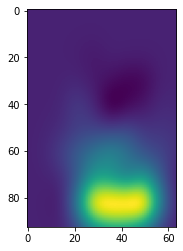

In [96]:
plt.imshow(field[15, :, :, 2])

In [98]:
# Write the meshes

movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source model(rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = itk.meshread(movingMeshPath)
for i in range(0, movingMesh.GetNumberOfPoints()):
    movingMesh.SetPoint(i, final_transform.TransformPoint(movingMesh.GetPoint(i)))

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh_itk1.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()


In [ ]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
                         
for n in range(0, numberOfPoints):
    movingPSNew.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

In [81]:
movingMesh_itk_np = itk.array_from_vector_container(movingMesh.GetPoints())
print(movingMesh_itk_np.shape)

(2351553, 3)


In [92]:
test1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData1/USNM174722-Cranium.vtk')
test2 = readvtk('movingMesh_itk.vtk')
test3 = readvtk('/home/pranjal.sahu/Documents/SampleApeData1/TPS Warped source model_1.vtk')

itkwidgets.view(geometries=[test1, test2, test3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [72]:
movingPS_np = itk.array_from_vector_container(movingPS.GetPoints())
fixedPS_np = itk.array_from_vector_container(fixedPS.GetPoints())
movingPSNew_np = itk.array_from_vector_container(movingPSNew.GetPoints())

itkwidgets.view(point_sets=[movingPS_np, movingPSNew_np, fixedPS_np])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

(55, 94, 64, 3)


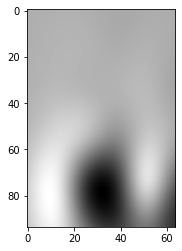

In [18]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')

In [6]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')
m2 = readvtk('ransacICPResult2_b.vtk')
#m3 = readvtk('ransacICPResult2_b_check.vtk')
m3 = readvtk('ransacICPResult2_c_check.vtk')


view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# TSD registration

imageDiagonal   = 50
stretchWeight   = 0.0001
bendWeight      = 0.0001
geometricWeight = 0.0001
maxStep         = 1
numOfIterations = 20
learningRate    = 1

movingMesh = itk.meshread('movingMesh.vtk', itk.D)
fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)

print('Number of Points are')
print(movingMesh.GetNumberOfPoints())
print(fixedMesh.GetNumberOfPoints())

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType        = itk.Mesh[itk.D, Dimension]
FixedImageType  = itk.Image[PixelType, Dimension]

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())


spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize    = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin    = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing   = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType  = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType, FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



MetricType = itk.ThinShellDemonsMetricv4.MD3
metric = MetricType.New()
metric.SetStretchWeight(stretchWeight)
metric.SetBendWeight(bendWeight)
metric.SetGeometricFeatureWeight(geometricWeight)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOff()
metric.UpdateFeatureMatchingAtEachIterationOn()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')


optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations( numOfIterations )
optimizer.SetMaximumStepSizeInPhysicalUnits( maxStep )
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( numOfIterations )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


print('Number of Transform Parameters ', transform.GetNumberOfParameters())

AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.InPlaceOn()

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of TSD Metric ', metric.GetValue())


# Get the Displacement field from the BSpline Transform
finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(finalTransform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())

itk.meshwrite(movingMesh, 'result_bspline.vtk')

In [ ]:
# Visualize the fixed mesh, moving mesh and the registered mesh

a = vtk.vtkPolyDataReader()
a.SetFileName('ransacICPResult2.vtk')
a.Update()
m1 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('result_bspline.vtk')
a.Update()
m2 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('fixedMesh.vtk')
a.Update()
m3 = a.GetOutput()

itkwidgets.view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
#finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

(24, 48, 29, 3)


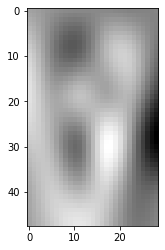

In [36]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')

In [172]:
# Checking Point to Plane ICP

import open3d as o3d
from open3d import geometry
from open3d import utility

source = geometry.PointCloud()
source.points = utility.Vector3dVector(itk_transformed_points)

target = geometry.PointCloud()
target.points = utility.Vector3dVector(fixedMeshPoints)

radius_normal = 5

target.estimate_normals(
    geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

trans_init = np.identity(4)
threshold = 10

convergence = o3d.pipelines.registration.TransformationEstimationPointToPlane()

print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init, convergence,
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000))

print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
#draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
RegistrationResult with fitness=6.731486e-01, inlier_rmse=4.562815e+00, and correspondence_set size of 2527
Access transformation to get result.
Transformation is:
[[  0.95502067   0.13828085  -0.26232407 -12.74522843]
 [ -0.11599785   0.98833485   0.09868494  14.89261294]
 [  0.27291026  -0.06381713   0.9599205   -9.09552887]
 [  0.           0.           0.           1.        ]]


In [173]:
# For getting distance after open 3d icp

sp = np.asarray(source_temp.points)
tp = np.asarray(target_temp.points)

print(sp.shape, tp.shape)

moving_ps = itk.Mesh[itk.D, 3].New()
fixed_ps = itk.Mesh[itk.D, 3].New()

fixed_ps.SetPoints(itk.vector_container_from_array(tp.flatten().astype('float32')))
moving_ps.SetPoints(itk.vector_container_from_array(sp.flatten().astype('float32')))

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(moving_ps)
metric.SetFixedPointSet(fixed_ps)
metric.Initialize()

print(metric.GetValue())

(3754, 3) (8002, 3)
8.35966483323909


In [135]:
print('final_mesh points ', final_mesh.shape[0])
print('fixedMeshPoints points ', fixedMeshPoints.shape[0])
print('itk_transformed_points points ', itk_transformed_points.shape[0])

final_mesh points  3754
fixedMeshPoints points  8002
itk_transformed_points points  3754


In [136]:
# For getting distance after ITK ICP

moving_ps = itk.Mesh[itk.D, 3].New()
fixed_ps = itk.Mesh[itk.D, 3].New()

fixed_ps.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten().astype('float32')))
#moving_ps.SetPoints(itk.vector_container_from_array(itk_transformed_points.flatten().astype('float32')))
moving_ps.SetPoints(itk.vector_container_from_array(final_mesh.flatten().astype('float32')))

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(fixed_ps)
metric.SetFixedPointSet(moving_ps)
metric.Initialize()

print(metric.GetValue())

9.055943657675051


In [130]:
print(fixed_ps.GetNumberOfPoints(), moving_ps.GetNumberOfPoints())

8002 3754


In [105]:
itkwidgets.view(point_sets=[sp, tp])

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157 , 0.        , 0.        ],
   …

In [102]:
source_temp = copy.deepcopy(source)
target_temp = copy.deepcopy(target)
source_temp.transform(reg_p2p.transformation)

PointCloud with 3754 points.

In [63]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [58]:
trans_init = np.identity(4)
print(trans_init)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [ ]:
movingMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Source Pointcloud (rigidly registered)_1.vtk'
fixedMeshPath = '/home/pranjal.sahu/Documents/SampleApeData1/Target Pointcloud_1.vtk'

movingMesh = readvtk(movingMeshPath)
fixedMesh  = readvtk(fixedMeshPath)

#itkwidgets.view(geometries=[fixedMesh, movingMesh])

print(movingMesh.GetNumberOfPoints())